In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import copy
import networkx as nx
import torch
from igraph import Graph

import sys
sys.path.append("../")
#from utils.reinforcement_learning.dqn_HD import DQN
from utils.reinforcement_learning.dqn_TS import DQN
from utils.hyperparameters.params import Params
from utils.evaluation.evaluationhelper import EvaluateModel,EvaluateACTION
from utils.environment.nodeCentrality import Node_Centrality
from utils.environment.globalFeature import Global_Feature
from utils.validation import get_Validation, area_under_curve
from utils.environment.game import GraphGame
from utils.environment.envhelper import reset
from utils.reinforcement_learning.rl_environment import Environment
from utils.getClass import objective_function,get_class_from_file
import time
        
    
def input_graph(graph_path,file):
    GRAPH = Graph.Read_Ncol(graph_path+str(file)+".txt", directed=False)
    nodes = [v.index for v in GRAPH.vs]
    map = {n:int(i) for i, n in enumerate(nodes)}
    GRAPH = reset(GRAPH)  
    Graph.simplify(GRAPH)
    return GRAPH, map

def implement_GNN(model_iteration,parameter_path,GRAPH,useSingleStep= None):
    params = Params(parameter_path)
    objectiveFunction = objective_function("utils/environment/objectiveFunction.py",params.objective_function)
    if objectiveFunction.__name__ == "numberConnectedComponent":
        condMaxNum = True
    else:
        condMaxNum = False
    model = torch.load(params.checkpoint_dir+'_'+str(model_iteration))
    game = GraphGame
    env = Environment(game)
    nodeCentrality = Node_Centrality(params.centrality_feature_name)
    globalFeature = Global_Feature(params.global_feature_name)
    attacker = DQN(state_representation_size=params.centrality_features,
                    hidden_layers_sizes= params.hidden_layers,
                   global_feature_size =params.global_features)
    attacker._q_network.load_state_dict(model["_q_network"])
    attacker._optimizer.load_state_dict(model["_optimizer"])
    rewards, lcc, actions = EvaluateModel(env,objectiveFunction,nodeCentrality,globalFeature, attacker,GRAPH,useSingleStep)
    return rewards, lcc, actions

def implement_random_GNN(agents,GRAPH):
    game = GraphGame
    env = Environment(game)
    rewards, lcc, actions = EvaluateModel(env, agents,GRAPH)
    return rewards, lcc, actions
    
def implement_Bench(fname,GRAPH,objectiveFunction,indexOn = False):
    if objectiveFunction.__name__ == "numberConnectedComponent":
        condMaxNum = True
    else:
        condMaxNum = False
    action_list = np.loadtxt(fname, dtype=int)
    rewards, lcc, actions = EvaluateACTION(action_list,objectiveFunction,GRAPH,indexOn)
    return rewards, lcc, actions
    #GRAPH.vertex["name"],

def visual_evaluation(graph_path,file_list,attacker,title,plot_grid,grid,StepSizes,save = False): 
    if grid[0] * grid[1] < 10:
        figure, axis = plt.subplots(grid[0],grid[1],sharex=True,figsize=(12, 10))
    else :
        figure, axis = plt.subplots(grid[0],grid[1],sharex=True,figsize=(22, 20))
    color_model = ['#d53e4f','#f46d43','#e6f598','#abdda4','#66c2a5', '#3288bd']    
    AUC  = []
    NodeRemoved = []
    auc_value = {}
    fraction_value = {}
    action = {}
    for i, graph_name in enumerate(file_list):
        print(graph_name, end=' ,')
        GRAPH, map = input_graph(graph_path,graph_name)
        N = GRAPH.vcount()
        params = Params(attacker[1]) 
        objectivefunction = params.objective_function
        objectiveFunction = objective_function("utils/environment/objectiveFunction.py",params.objective_function)
        # Trained MIXED
        x =  np.flip(np.arange(N+1)[N:0:-1]/N)
        for color_code,steps in enumerate(StepSizes):
            tic = time.perf_counter()
            rewards, lcc, actions= implement_GNN(attacker[0],attacker[1],GRAPH.copy(),useSingleStep=steps)
            toc = time.perf_counter()
            if steps != None:
                print(f"Step {int(steps*100):d}%: RunTime in {toc - tic:0.4f} seconds")
            else:
                print(f"Sequential: RunTime in {toc - tic:0.4f} seconds")
            if objectiveFunction.__name__ == "numberConnectedComponent":
                lcc = np.array(lcc)
                lcc = (lcc[-1] - lcc + 1)/lcc[-1]
            if steps == None: 
                axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc)],np.array(lcc)/lcc[0], color = color_model[color_code],label="Sequential")
            else:
                axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc)],np.array(lcc)/lcc[0], color = color_model[color_code],label=str(steps*100)+"%")
        axis[plot_grid[i][0],plot_grid[i][1]].set_title(graph_name, fontdict={'fontsize': 18})
        if i == 0 :
            axis[plot_grid[i][0],plot_grid[i][1]].legend(loc="upper right")
    figure.text(0.5, 0.075,"Fraction of Nodes Removed" , fontsize = 18,  ha='center')
    if objectiveFunction == "numberConnectedComponent":
        figure.text(0.075, 0.5, "N -"+ objectivefunction+"/N", fontsize = 18,  va='center', rotation='vertical')
    else:
        figure.text(0.075, 0.5, objectivefunction+"/N", fontsize = 18,  va='center', rotation='vertical')
    if save:
        plt.savefig("./Figure/Compiled/HDA/"+title+".pdf")
    plt.show()

# Real World Dataset: MinMax Problem - Largest Connected Component

foodweb-baywet ,

/home/bhandk/AttackandDefend/utils/environment/nodeCentrality.py:24: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  x = np.column_stack(centrality.values())


Sequential: RunTime in 13.4719 seconds
Step 10%: RunTime in 0.5046 seconds
Step 20%: RunTime in 0.6402 seconds
Step 50%: RunTime in 0.3448 seconds
Step 100%: RunTime in 0.2512 seconds
inf-USAir97 ,Sequential: RunTime in 6.0958 seconds
Step 10%: RunTime in 1.2700 seconds
Step 20%: RunTime in 1.4525 seconds
Step 50%: RunTime in 1.0503 seconds
Step 100%: RunTime in 1.2247 seconds
moreno_crime_projected ,Sequential: RunTime in 94.5926 seconds
Step 10%: RunTime in 9.3008 seconds
Step 20%: RunTime in 6.3863 seconds
Step 50%: RunTime in 7.1916 seconds
Step 100%: RunTime in 8.8804 seconds
opsahl-openflights ,Sequential: RunTime in 1732.1933 seconds
Step 10%: RunTime in 132.5666 seconds
Step 20%: RunTime in 184.8334 seconds
Step 50%: RunTime in 166.5365 seconds
Step 100%: RunTime in 164.5919 seconds
household ,Sequential: RunTime in 367.2389 seconds
Step 10%: RunTime in 12.3075 seconds
Step 20%: RunTime in 9.0932 seconds
Step 50%: RunTime in 8.2411 seconds
Step 100%: RunTime in 11.7828 seconds


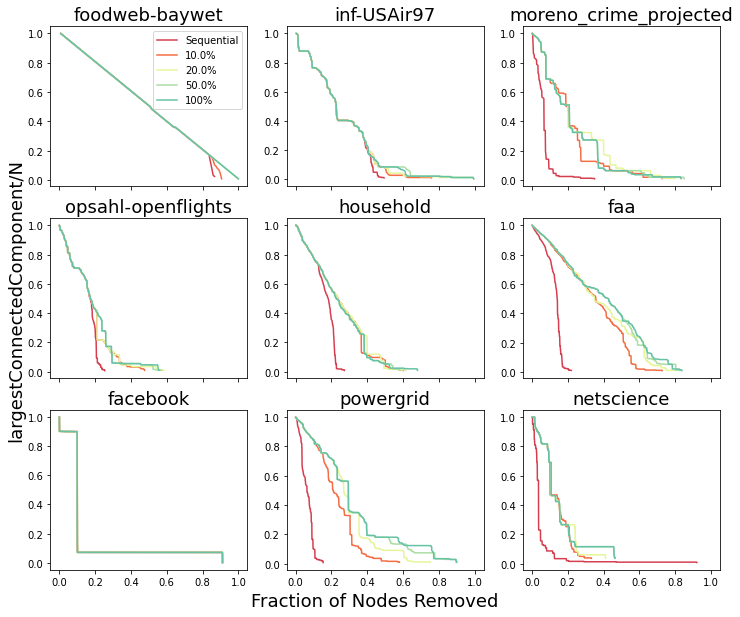

foodweb-baywet ,

/home/bhandk/AttackandDefend/utils/environment/nodeCentrality.py:24: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  x = np.column_stack(centrality.values())


Sequential: RunTime in 2.5058 seconds
Step 10%: RunTime in 0.4018 seconds
Step 20%: RunTime in 0.2888 seconds
Step 50%: RunTime in 0.1898 seconds
Step 100%: RunTime in 0.2411 seconds
inf-USAir97 ,Sequential: RunTime in 3.3640 seconds
Step 10%: RunTime in 0.6649 seconds
Step 20%: RunTime in 0.7786 seconds
Step 50%: RunTime in 1.1411 seconds
Step 100%: RunTime in 1.0795 seconds
moreno_crime_projected ,Sequential: RunTime in 89.1673 seconds
Step 10%: RunTime in 10.4470 seconds
Step 20%: RunTime in 9.8910 seconds
Step 50%: RunTime in 8.4182 seconds
Step 100%: RunTime in 8.9933 seconds
opsahl-openflights ,Sequential: RunTime in 935.2742 seconds
Step 10%: RunTime in 295.6643 seconds
Step 20%: RunTime in 307.4188 seconds
Step 50%: RunTime in 301.5057 seconds
Step 100%: RunTime in 293.5258 seconds
household ,Sequential: RunTime in 288.2875 seconds
Step 10%: RunTime in 10.8243 seconds
Step 20%: RunTime in 12.5115 seconds
Step 50%: RunTime in 12.0473 seconds
Step 100%: RunTime in 11.8803 seconds

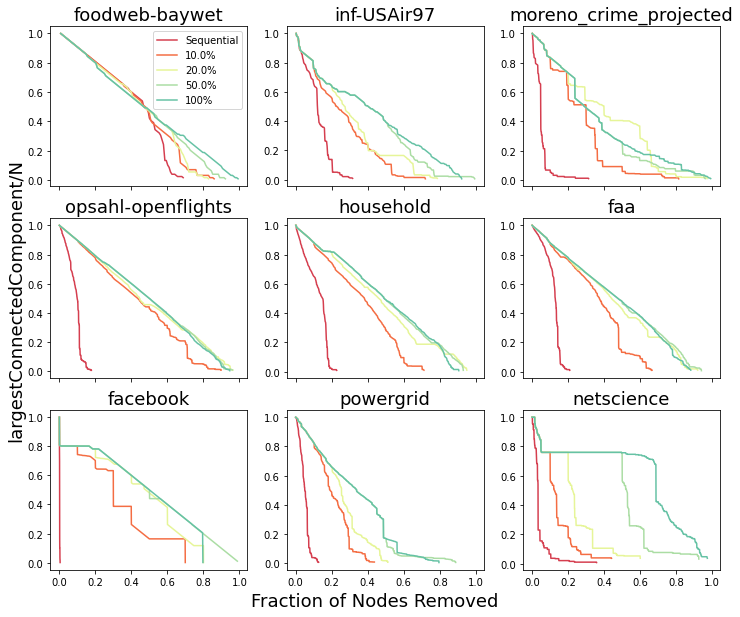

In [2]:
BA = 166000 # BEST ND 178000
MIX = 85000 #BEST ND140500  
parameter = ["./utils/hyperparameters/BA/ba_params_Best.json","./utils/hyperparameters/Mix/mixed_params_All.json"]
attacker= [BA,MIX]
file_list = ["foodweb-baywet","inf-USAir97","moreno_crime_projected",'opsahl-openflights','household','faa','facebook','powergrid','netscience']
#file_list = ["test","corruption","foodweb-baywet","inf-USAir97","moreno_crime_projected"]
graph_path =  "./Dataset/Real/"
x, y = 3, 3
grid_plot = [[i,j] for i in range(x) for j in range(y)]
StepSizes = [None,0.1,0.2,0.5,1]
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],"MinMax_BA_StepSize",grid_plot,[x,y],StepSizes,save =True)
visual_evaluation(graph_path,file_list,[attacker[1],parameter[1]],"MinMax_MIX_StepSize",grid_plot,[x,y],StepSizes,save =True)


# Real World Dataset: CNP Problem - Pairwise Connectivity Component

foodweb-baywet ,

/home/bhandk/AttackandDefend/utils/environment/nodeCentrality.py:24: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  x = np.column_stack(centrality.values())


Sequential: RunTime in 2.4496 seconds
Step 10%: RunTime in 0.4034 seconds
Step 20%: RunTime in 0.3619 seconds
Step 50%: RunTime in 0.2126 seconds
Step 100%: RunTime in 0.1111 seconds
inf-USAir97 ,Sequential: RunTime in 2.5585 seconds
Step 10%: RunTime in 1.2524 seconds
Step 20%: RunTime in 0.9930 seconds
Step 50%: RunTime in 0.9510 seconds
Step 100%: RunTime in 0.9410 seconds
moreno_crime_projected ,Sequential: RunTime in 58.5846 seconds
Step 10%: RunTime in 10.2252 seconds
Step 20%: RunTime in 9.5564 seconds
Step 50%: RunTime in 9.0055 seconds
Step 100%: RunTime in 8.2592 seconds
opsahl-openflights ,Sequential: RunTime in 1126.4128 seconds
Step 10%: RunTime in 360.5930 seconds
Step 20%: RunTime in 347.8276 seconds
Step 50%: RunTime in 308.3048 seconds
Step 100%: RunTime in 292.8149 seconds
household ,Sequential: RunTime in 291.8883 seconds
Step 10%: RunTime in 21.2017 seconds
Step 20%: RunTime in 16.8495 seconds
Step 50%: RunTime in 13.4286 seconds
Step 100%: RunTime in 13.9192 second

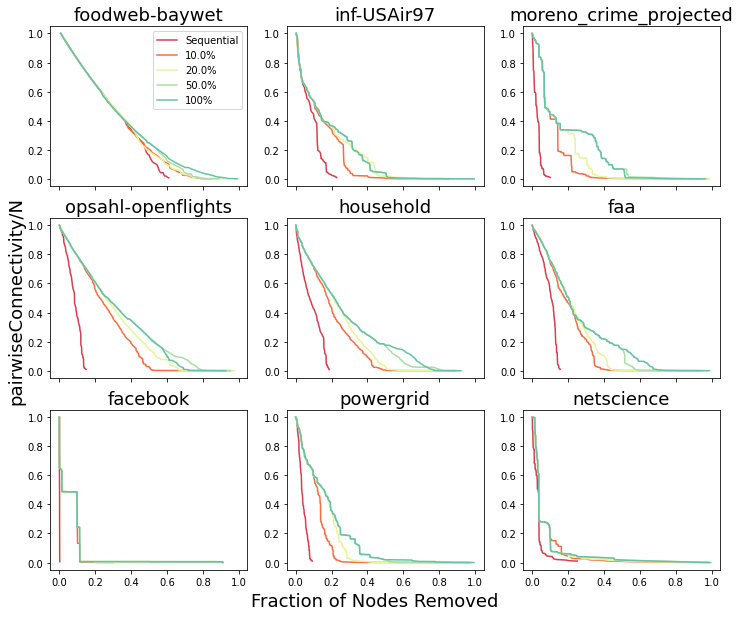

foodweb-baywet ,

/home/bhandk/AttackandDefend/utils/environment/nodeCentrality.py:24: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  x = np.column_stack(centrality.values())


Sequential: RunTime in 2.2331 seconds
Step 10%: RunTime in 0.3714 seconds
Step 20%: RunTime in 0.2210 seconds
Step 50%: RunTime in 0.3250 seconds
Step 100%: RunTime in 0.2129 seconds
inf-USAir97 ,Sequential: RunTime in 2.5930 seconds
Step 10%: RunTime in 0.8781 seconds
Step 20%: RunTime in 1.0154 seconds
Step 50%: RunTime in 1.0985 seconds
Step 100%: RunTime in 0.9560 seconds
moreno_crime_projected ,Sequential: RunTime in 43.2015 seconds
Step 10%: RunTime in 8.8846 seconds
Step 20%: RunTime in 8.4739 seconds
Step 50%: RunTime in 7.9316 seconds
Step 100%: RunTime in 8.0407 seconds
opsahl-openflights ,Sequential: RunTime in 1045.7655 seconds
Step 10%: RunTime in 291.2135 seconds
Step 20%: RunTime in 324.3053 seconds
Step 50%: RunTime in 301.7445 seconds
Step 100%: RunTime in 314.4223 seconds
household ,Sequential: RunTime in 256.3375 seconds
Step 10%: RunTime in 19.3735 seconds
Step 20%: RunTime in 17.0722 seconds
Step 50%: RunTime in 14.2542 seconds
Step 100%: RunTime in 12.9160 seconds

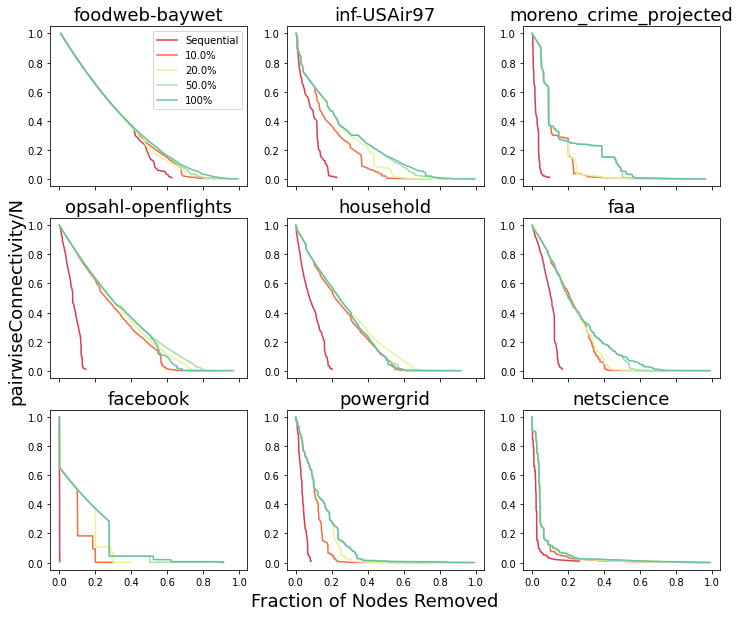

In [3]:
BA = 137000 # BEST ND 178000
MIX = 98500 #BEST ND140500  
parameter = ["./utils/hyperparameters/BA/ba_params_CN.json","./utils/hyperparameters/Mix/mixed_params_CN.json"]
attacker= [BA,MIX]
file_list = ["foodweb-baywet","inf-USAir97","moreno_crime_projected",'opsahl-openflights','household','faa','facebook','powergrid','netscience']
#file_list = ["test","corruption","foodweb-baywet","inf-USAir97","moreno_crime_projected"]
graph_path =  "./Dataset/Real/"
x, y = 3, 3
grid_plot = [[i,j] for i in range(x) for j in range(y)]
StepSizes = [None,0.1,0.2,0.5,1]
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],"CNP_BA_StepSize",grid_plot,[x,y],StepSizes,save =True)
visual_evaluation(graph_path,file_list,[attacker[1],parameter[1]],"CNP_MIX_StepSize",grid_plot,[x,y],StepSizes,save =True)



# Real World Dataset: MaxNum - Number of Connected Components

foodweb-baywet ,

/home/bhandk/AttackandDefend/utils/environment/nodeCentrality.py:24: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  x = np.column_stack(centrality.values())


Step 10%: RunTime in 10.8258 seconds
Step 20%: RunTime in 0.3514 seconds
Step 50%: RunTime in 0.3023 seconds
Step 100%: RunTime in 0.1584 seconds
Sequential: RunTime in 4.0198 seconds
inf-USAir97 ,Step 10%: RunTime in 1.5838 seconds
Step 20%: RunTime in 1.3299 seconds
Step 50%: RunTime in 1.1745 seconds
Step 100%: RunTime in 1.1757 seconds
Sequential: RunTime in 7.4912 seconds
moreno_crime_projected ,Step 10%: RunTime in 13.2130 seconds
Step 20%: RunTime in 10.5432 seconds
Step 50%: RunTime in 9.5933 seconds
Step 100%: RunTime in 8.6175 seconds
Sequential: RunTime in 84.3194 seconds
opsahl-openflights ,Step 10%: RunTime in 372.6737 seconds
Step 20%: RunTime in 336.5414 seconds
Step 50%: RunTime in 337.4716 seconds
Step 100%: RunTime in 349.1803 seconds
Sequential: RunTime in 1961.6207 seconds
household ,Step 10%: RunTime in 21.0677 seconds
Step 20%: RunTime in 15.3781 seconds
Step 50%: RunTime in 11.7226 seconds
Step 100%: RunTime in 12.7363 seconds
Sequential: RunTime in 321.0277 seco

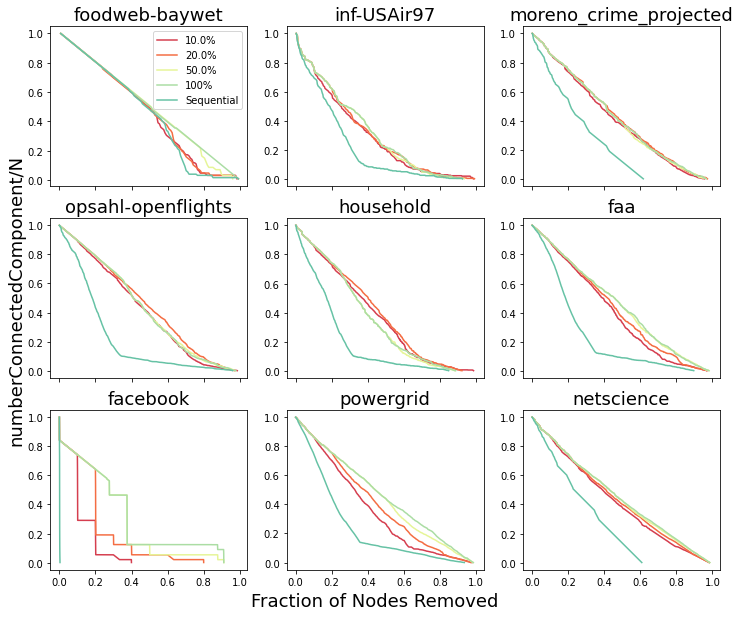

foodweb-baywet ,

/home/bhandk/AttackandDefend/utils/environment/nodeCentrality.py:24: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  x = np.column_stack(centrality.values())


Step 10%: RunTime in 0.3766 seconds
Step 20%: RunTime in 0.2647 seconds
Step 50%: RunTime in 0.1682 seconds
Step 100%: RunTime in 0.2028 seconds
Sequential: RunTime in 1.8783 seconds
inf-USAir97 ,Step 10%: RunTime in 0.9685 seconds
Step 20%: RunTime in 1.0624 seconds
Step 50%: RunTime in 0.9291 seconds
Step 100%: RunTime in 0.9536 seconds
Sequential: RunTime in 3.3213 seconds
moreno_crime_projected ,Step 10%: RunTime in 10.0150 seconds
Step 20%: RunTime in 8.3548 seconds
Step 50%: RunTime in 7.9241 seconds
Step 100%: RunTime in 8.0706 seconds
Sequential: RunTime in 106.4880 seconds
opsahl-openflights ,Step 10%: RunTime in 290.2626 seconds
Step 20%: RunTime in 283.6243 seconds
Step 50%: RunTime in 283.9552 seconds
Step 100%: RunTime in 296.3968 seconds
Sequential: RunTime in 1126.5438 seconds
household ,Step 10%: RunTime in 20.0933 seconds
Step 20%: RunTime in 15.8988 seconds
Step 50%: RunTime in 13.1700 seconds
Step 100%: RunTime in 12.7109 seconds
Sequential: RunTime in 249.4509 secon

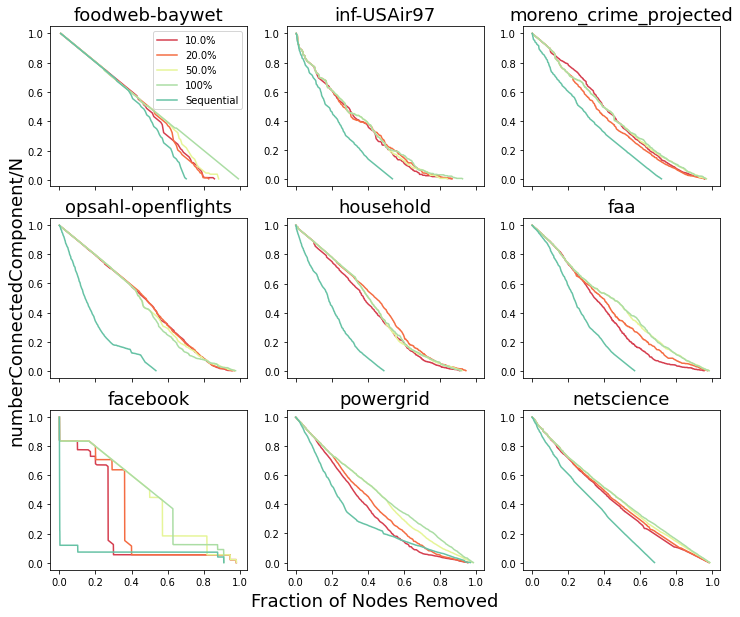

In [2]:
BA = 258500 # BEST ND 178000
MIX = 284000 #BEST ND140500  
parameter = ["./utils/hyperparameters/BA/ba_params_MaxNum.json","./utils/hyperparameters/Mix/mixed_params_MaxNum.json"]
attacker= [BA,MIX]
file_list = ["foodweb-baywet","inf-USAir97","moreno_crime_projected",'opsahl-openflights','household','faa','facebook','powergrid','netscience']
#file_list = ["test","corruption","foodweb-baywet","inf-USAir97","moreno_crime_projected"]
graph_path =  "./Dataset/Real/"
x, y = 3, 3
grid_plot = [[i,j] for i in range(x) for j in range(y)]
StepSizes = [0.1,0.2,0.5,1,None]
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],"MaxNum_BA_StepSize",grid_plot,[x,y],StepSizes,save =True)
visual_evaluation(graph_path,file_list,[attacker[1],parameter[1]],"MaxNum_MIX_StepSize",grid_plot,[x,y],StepSizes,save =True)

